### Business Requirement: 
From: Finance Department

To: Data Science Department

Subject: Financial Delinquency Project

We've collected our data. And we've noticed that you know what one of the biggest losses to our company is when companies go bankrupt and for our various investment strategies. So what we'd like to do is take a look at our historical data and see if there's any way that we can predict in the future that a company might go bankrupt, so that we can divest ourselves ahead of time.

From: Finance Department 

To: Data Science Department

Subject: RE: Financial Delinquency Project

Oh, and just to clarify, this dataset is collected over five years, but we don't care the exact year that a company will go bankrupt, just whether or not they will go bankrupt at all, based on the data. Thanks!

The dataset is about bankruptcy prediction of Polish companies. The data was collected from Emerging Markets Information Service (EMIS, which is a database containing information on emerging markets around the world. The bankrupt companies were analyzed in the period 2000-2012, while the still operating companies were evaluated from 2007 to 2013.

Basing on the collected data five classification cases were distinguished, that depends on the forecasting period:

 

- 1stYear : the data contains financial rates from 1st year of the forecasting period and corresponding class label that indicates bankruptcy status after 5 years. The data contains 7027 instances (financial statements), 271 represents bankrupted companies, 6756 firms that did not bankrupt in the forecasting period.

 

- 2ndYear :  the data contains financial rates from 2nd year of the forecasting period and corresponding class label that indicates bankruptcy status after 4 years. The data contains 10173 instances (financial statements), 400 represents bankrupted companies, 9773 firms that did not bankrupt in the forecasting period.

 

- 3rdYear : the data contains financial rates from 3rd year of the forecasting period and corresponding class label that indicates bankruptcy status after 3 years. The data contains 10503 instances (financial statements), 495 represents bankrupted companies, 10008 firms that did not bankrupt in the forecasting period.

- 4thYear : the data contains financial rates from 4th year of the forecasting period and corresponding class label that indicates bankruptcy status after 2 years. The data contains 9792 instances (financial statements), 515 represents bankrupted companies, 9277 firms that did not bankrupt in the forecasting period.

- 5thYear : the data contains financial rates from 5th year of the forecasting period and corresponding class label that indicates bankruptcy status after 1 year. The data contains 5910 instances (financial statements), 410 represents bankrupted companies, 5500 firms that did not bankrupt in the forecasting period.

In [1]:
# To supress warnings
import warnings
warnings.filterwarnings("ignore")

#for data
import pandas as pd 
import numpy as np 

# scikit-learn's SimpleImputer to replace "nan" values
from sklearn.impute import SimpleImputer

# Display all columns 
pd.options.display.max_columns = None
## for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
## for statistical tests
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm

## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from yellowbrick.classifier import ClassificationReport

#Xgboost
import xgboost as xgb

# RandomForest
from sklearn.ensemble import RandomForestClassifier

# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

from imblearn.over_sampling import SMOTE

from sklearn.metrics import accuracy_score

import time
import os
# For loading .arff files
from scipy.io import arff
import urllib.request
import io # for io.StringIO()
import copy
# To analyze the type of missing data
import missingno as msno


#### Common functions

In [28]:
# this feature will impute the some of missing data features
def impute_Features(feature_name, df_impute):
    fill_nan_payer = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
    df_impute[feature_name] = fill_nan_payer.fit_transform(df_impute.loc[:,feature_name].values)

# this will impute the columns with mode
def grouper_impute(df_Impute): 
    f = lambda x: x.mode().iloc[0]
    df_Impute = df_Impute.fillna(df_Impute.groupby('class').transform(f))
    return df_Impute

# generate the sparsity matrix (figure) 
def generate_sparsity_matrix(df_missing):
    missing_df = df_missing.columns[df_missing.isnull().any()].tolist()
    msno.matrix(df_missing[missing_df], figsize=(30,10), labels=True)
    
# cross validate all models   
def build_run_models(X, y, model_objects, model_names):
    scores = np.zeros(len(model_objects))

    for i in np.arange(len(model_objects)):
        print(model_names[i])
        scores[i] = np.mean(model_selection.cross_validate(model_objects[i], 
                                                           X, 
                                                           y, 
                                                           scoring="roc_auc", 
                                                           cv=5, 
                                                           return_train_score=False)["test_score"])
       
    return pd.DataFrame(scores, index=model_names, columns=["Score"])

def plot_class_dist(y, target_label = None):
    fig, axarr = plt.subplots(1, 2, figsize=(18, 6))
    class_ct = len(np.unique(y))
    vc = pd.value_counts(y)
    print('Total Records', len(y))
    print('Total Classes:', class_ct)
    print('Class Gini Index', gini_index(y))
    print('Smallest Class Id:',vc.idxmin(),'Records:',vc.min())
    print('Largest Class Id:',vc.idxmax(),'Records:',vc.max())
    print('Accuracy when Guessing:', np.round( (1 / len(np.unique(y))) * 100, 2), '%')

    sns.distplot(y, ax=axarr[0], bins=class_ct).set_title('Target Class Distribution:', target_label);
    sns.distplot(y, ax=axarr[1], kde=False, bins=class_ct).set_title('Target Class Counts:', target_label);

def gini_index(y):
    probs = pd.value_counts(y,normalize=True)
    return 1 - np.sum(np.square(probs))

def plot_confusion_matrix(y_test, y_hat):
    cm=metrics.confusion_matrix(y_test, y_hat)
    cm/np.sum(cm)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{var1}\n{var2}\n{var3}" for var1,var2,var3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    plt.figure(figsize=(7,5))

    sns.heatmap(cm,
                annot=labels,
                fmt='',
                cmap='coolwarm',
                xticklabels=['Negative or 0','Positive or 1'],
                yticklabels=['Negative or 0','Positive or 1'],
                annot_kws={'size':16})

    plt.title('Confusion Matrix')
    plt.show()

# this function will plot precision and recall curve
def plot_precision_recall(X_test, y_test, model):
    y_score = model.decision_function(X_test)
    average_precision = average_precision_score(y_test, y_score)
    disp = plot_precision_recall_curve(model, X_test, y_test)

    disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))
    
def plot_AUC_roc_curve_(y_test, y_pred, classifier, model_name):
    ns_probs = [0 for _  in range(len(y_test))]
    y_pred_prob = classifier.predict_proba(X_test)
    y_pred_prob = y_pred_prob[:,1]
    ns_auc = metrics.roc_auc_score(y_test,ns_probs)

    ns_fpr,ns_tpr, _ = metrics.roc_curve(y_test,ns_probs)
    classifier_fpr,classifier_tpr, _ = metrics.roc_curve(y_test,y_pred_prob)

    nb_roc_auc = metrics.roc_auc_score(y_test,y_pred)

    plt.plot(ns_fpr,ns_tpr,linestyle = '--',color='red')
    plt.plot(classifier_fpr,classifier_tpr,marker='o',color='orange',label= model_name + ' (area = %0.3f)' % nb_roc_auc)
    plt.ylabel('True Positive Rate',size=14)
    plt.xlabel('False Positive Rate',size=14)
    plt.title(model_name + ' AUC-ROC curve',size=18)
    plt.rcParams['axes.spines.right']=True # remove the plot border
    plt.rcParams['axes.spines.left']=True # remove the plot border
    plt.rcParams['axes.spines.top']=True # remove the plot border
    plt.rcParams['axes.spines.bottom']=True #
    plt.legend() 
    plt.show()
    
    


#### Load the data 

In [3]:
# Read arff files 
ftpstream_year_one = urllib.request.urlopen('https://raw.githubusercontent.com/rajeshsk/QTW/main/CaseStudy4/case_study_4_data/1year.arff')
year_one = arff.loadarff(io.StringIO(ftpstream_year_one.read().decode('utf-8')))

ftpstream_year_two = urllib.request.urlopen('https://raw.githubusercontent.com/rajeshsk/QTW/main/CaseStudy4/case_study_4_data/2year.arff')
year_two = arff.loadarff(io.StringIO(ftpstream_year_two.read().decode('utf-8')))

ftpstream_year_three = urllib.request.urlopen('https://raw.githubusercontent.com/rajeshsk/QTW/main/CaseStudy4/case_study_4_data/3year.arff')
year_three = arff.loadarff(io.StringIO(ftpstream_year_three.read().decode('utf-8')))

ftpstream_year_four = urllib.request.urlopen('https://raw.githubusercontent.com/rajeshsk/QTW/main/CaseStudy4/case_study_4_data/4year.arff')
year_four = arff.loadarff(io.StringIO(ftpstream_year_four.read().decode('utf-8')))

ftpstream_year_five = urllib.request.urlopen('https://raw.githubusercontent.com/rajeshsk/QTW/main/CaseStudy4/case_study_4_data/5year.arff')
year_five = arff.loadarff(io.StringIO(ftpstream_year_five.read().decode('utf-8')))

In [4]:
# Create dataframe for each years
df1=pd.DataFrame(year_one[0])
df2=pd.DataFrame(year_two[0])
df3 =pd.DataFrame(year_three[0])
df4=pd.DataFrame(year_four[0])
df5=pd.DataFrame(year_five[0])
# Combine all dataframe into one big dataframe
df = pd.concat([df1,df2,df3,df4,df5])
# Feature descriptions
feature_desc = pd.read_csv('https://raw.githubusercontent.com/rajeshsk/QTW/main/CaseStudy4/case_study_4_data/CS4Metadata.txt',delimiter='\t')
# shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)

In [5]:
df.shape

(43405, 65)

In [6]:
df.head()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr37,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,0.071010,0.438190,0.169180,1.75070,12.8670,0.00000,0.092551,1.28210,1.88020,0.56181,0.118420,0.410660,0.095523,0.092551,890.51,0.409880,2.28210,0.092551,0.049223,20.093,1.18540,0.115330,0.037766,0.23756,0.55259,0.360720,4.45890,0.279420,4.1144,0.162910,0.061241,46.0530,7.9256,4.07630,0.094037,1.88020,2.2425,0.69159,0.050013,0.60708,0.072171,0.061338,50.03100,29.93800,0.68604,1.29140,21.151,0.028276,0.015038,0.90040,0.225370,0.126170,0.92791,1.14230,2201.600,0.050013,0.12640,0.95288,0.23101,18.1650,12.1920,43.7500,8.3429,3.10550,b'0'
1,0.122350,0.473350,0.450840,1.95250,-3.6710,0.00000,0.156450,1.11260,2.60370,0.52665,0.167860,0.330510,0.115920,0.156450,572.44,0.637620,2.11260,0.156450,0.060087,65.937,NaN,0.167860,0.046992,0.15645,0.38404,0.565590,14.71200,5.947100,2.5448,0.067136,0.060087,70.9330,5.1457,5.14570,0.167980,2.60370,NaN,0.52665,0.064515,0.63883,0.050374,0.064469,87.16800,21.23100,0.26013,0.95878,70.484,0.022491,0.008638,1.95250,0.473350,0.194340,6.94710,6.94710,158.060,0.064516,0.23232,0.93992,0.00000,5.5356,17.1920,66.3560,5.5006,34.34500,b'0'
2,-0.627730,1.392900,0.026348,9.10500,9.6232,-0.57493,-0.627730,-0.28205,0.88493,-0.39285,-0.311810,-193.100000,-0.534570,-0.627730,-1074.70,-0.339630,0.71795,-0.627730,-0.709350,0.000,0.39595,-0.312210,-0.709350,-0.80952,-1.20270,-0.339630,-0.98829,0.027151,2.9367,1.543500,-0.380690,1.0541,346.2700,0.80816,-0.240720,0.88493,0.0213,0.99675,-0.272020,8.40460,-0.294700,-0.352810,0.93906,0.93906,NaN,9.10500,0.000,-0.466890,-0.527600,0.02125,0.003251,0.002888,-0.40484,1.02720,22.775,-0.272020,1.59790,1.64660,-3.53720,NaN,388.6900,1.3408,272.2200,0.91192,b'0'
3,-0.129080,0.082658,0.239210,3.89400,79.8160,-0.38650,-0.128960,10.64800,0.85313,0.88014,-0.128960,-1.560100,-0.006852,-0.128960,-5436.20,-0.067142,12.09800,-0.128960,-0.159220,24.855,0.92473,-0.126660,-0.159370,-0.38178,0.88014,-0.068573,-1.33420,0.352750,4.2128,-0.086597,-0.159220,31.7800,11.4850,-1.53240,-0.126660,0.83547,NaN,0.88014,-0.156390,1.85990,-0.834960,-0.156390,75.77300,50.91800,-2.34040,3.22670,21.205,-0.250070,-0.308760,3.89400,0.082658,0.087068,1.29790,1.29790,3904.200,-0.172150,-0.14665,1.17220,0.00000,14.6850,7.1685,37.2510,9.7984,1.19430,b'0'
4,0.038033,0.868250,-0.088667,0.84292,-40.7000,0.00000,0.038033,0.15174,1.75650,0.13175,0.071278,0.067378,0.036388,0.038033,4958.20,0.073616,1.15170,0.038033,0.021652,21.082,1.01780,0.071275,0.021652,0.12883,0.12684,0.073616,2.14390,-0.169150,3.9152,0.487840,0.034654,115.1900,3.1686,2.06000,-0.032035,1.75650,1.4984,0.38158,-0.018237,0.03632,0.297880,0.040577,94.60900,73.52700,0.37488,0.66319,20.704,0.045390,0.025841,0.54799,0.564470,0.315600,0.25133,0.72792,-729.440,-0.018237,0.28868,0.97955,1.89630,17.3140,4.9642,117.2900,3.1119,3.35090,b'0'


In [7]:
df.describe()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr37,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64
count,43397.000000,43397.000000,43397.000000,43271.000000,4.331600e+04,43397.000000,43397.000000,43311.000000,43396.000000,43397.000000,43361.000000,43271.000000,43278.000000,43397.000000,4.336900e+04,43310.000000,43311.000000,43397.000000,43277.000000,4.327800e+04,37551.000000,43397.000000,43278.000000,42483.000000,43397.000000,43310.000000,4.064100e+04,42593.000000,43397.000000,43278.000000,43278.000000,4.303700e+04,43271.000000,43311.000000,43397.000000,43397.000000,24421.000000,43397.000000,43278.000000,43271.000000,42651.000000,43278.000000,4.327800e+04,4.327800e+04,41258.000000,43270.000000,4.310800e+04,43396.000000,43278.000000,43311.000000,43397.000000,43104.000000,42593.000000,42593.000000,4.340400e+04,4.327800e+04,43398.000000,4.332100e+04,43398.000000,4.125300e+04,43303.000000,4.327800e+04,43271.000000,42593.000000
mean,0.035160,0.590212,0.114431,6.314702,-3.853466e+02,-0.056107,0.093478,12.640779,2.652166,0.626868,0.131075,1.132430,0.809544,0.093489,1.991890e+03,1.411167,13.802535,0.098565,0.156277,2.430209e+02,3.884997,0.113923,0.138582,0.270012,0.392844,1.263864,1.107896e+03,6.003208,4.005020,7.370821,0.176847,1.162621e+03,8.636016,5.411439,0.111908,2.911241,105.085363,0.724357,-0.289102,2.147411,7.717806,-0.142514,1.074125e+03,8.311085e+02,14.825016,5.428857,3.578418e+02,0.028584,-0.482584,5.835373,0.483521,6.478459,23.772623,24.654700,7.672188e+03,-2.621959e+01,-0.010510,3.002644e+01,1.333288,4.480858e+02,17.033202,1.502328e+03,9.343074,72.788592
std,2.994109,5.842748,5.439429,295.434425,6.124303e+04,7.201326,5.713075,505.894281,62.932732,14.670597,5.306782,67.590296,86.944053,5.713075,9.643193e+04,68.519998,507.322101,5.737645,48.692154,3.754517e+04,228.668931,5.155778,48.334974,7.988151,12.891440,66.224124,3.501237e+04,153.468628,0.826857,814.490078,48.748410,9.559356e+04,118.991185,120.975110,4.783398,62.984347,3058.429830,14.749270,39.256360,56.029879,1398.837543,15.990988,1.472188e+05,1.100510e+05,2428.236110,295.356200,3.314634e+04,5.097322,45.152174,307.382687,5.438357,639.887467,1213.797976,1220.884065,7.005310e+04,5.327862e+03,13.674072,5.334454e+03,122.104445,3.234560e+04,553.049406,1.392667e+05,124.177354,2369.339482
min,-463.890000,-430.870000,-479.960000,-0.403110,-1.190300e+07,-508.410000,-517.480000,-141.410000,-3.496000,-479.910000,-463.890000,-6331.800000,-1460.600000,-517.480000,-9.632400e+06,-6331.800000,-0.412920,-517.480000,-1578.700000,-2.934000e+01,-1325.000000,-431.590000,-1578.700000,-463.890000,-500.930000,-6331.800000,-2.590100e+05,-3829.900000,-0.886060,-6351.700000,-1495.600000,-9.295600e+03,-19.197000,-1696.000000,-431.590000,-0.000857,-525.520000,-479.910000,-7522.000000,-101.270000,-1234.400000,-1395.800000,-1.158700e+05,-1.158700e+05,-256230.000000,-101.260000,-9.611000e+01,-542.560000,-9001.000000,-0.045239,-0.186610,-25.467000,-3828.900000,-3828.900000,-1.805200e+06,-1.108300e+06,-1667.300000,-1.986900e+02,-327.970000,-1.244000e+01,-12.656000,-2.336500e+06,-1.543200,-10677.000000
25%,0.003429,0.268980,0.021521,1.049500,-4.908000e+01,0.000000,0.005776,0.430275,1.018500,0.295470,0.015409,0.015072,0.023881,0.005783,2.225800e+02,0.073476,1.451650,0.005783,0.003870,1.541325e+01,0.908225,0.000000,0.002269,0.021336,0.150100,0.066743,4.504800e-02,0.038214,3.495100,0.082753,0.006961,4.639500e+01,2.819900,0.305725,0.006038,1.101100,1.142300,0.419830,0.004165,0.052696,0.026679,0.000000,6.660850e+01,3.487775e+01,0.019168,0.607455,1.622575e+01,-0.038183,-0.026674,0.774935,0.190060,0.126937,0.686780,0.956330,2.755425e+01,9.348500e-03,0.014649,8.753200e-01,0.0

In [8]:
feature_desc

,Attribute Information:
0,X1 net profit / total assets
1,X2 total liabilities / total assets
2,X3 working capital / total assets
3,X4 current assets / short-term liabilities
4,X5 [(cash + short-term securities + receivable...
...,...
59,X60 sales / inventory
60,X61 sales / receivables
61,X62 (short-term liabilities *365) / sales
62,X63 sales / short-term liabilities


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43405 entries, 0 to 43404
Data columns (total 65 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Attr1   43397 non-null  float64
 1   Attr2   43397 non-null  float64
 2   Attr3   43397 non-null  float64
 3   Attr4   43271 non-null  float64
 4   Attr5   43316 non-null  float64
 5   Attr6   43397 non-null  float64
 6   Attr7   43397 non-null  float64
 7   Attr8   43311 non-null  float64
 8   Attr9   43396 non-null  float64
 9   Attr10  43397 non-null  float64
 10  Attr11  43361 non-null  float64
 11  Attr12  43271 non-null  float64
 12  Attr13  43278 non-null  float64
 13  Attr14  43397 non-null  float64
 14  Attr15  43369 non-null  float64
 15  Attr16  43310 non-null  float64
 16  Attr17  43311 non-null  float64
 17  Attr18  43397 non-null  float64
 18  Attr19  43277 non-null  float64
 19  Attr20  43278 non-null  float64
 20  Attr21  37551 non-null  float64
 21  Attr22  43397 non-null  float64
 22

In [10]:
for f,d in zip(df.columns,feature_desc['Attribute Information:']):
    print()
    print(f,'-->',d)


Attr1 --> X1 net profit / total assets

Attr2 --> X2 total liabilities / total assets

Attr3 --> X3 working capital / total assets

Attr4 --> X4 current assets / short-term liabilities

Attr5 --> X5 [(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365

Attr6 --> X6 retained earnings / total assets

Attr7 --> X7 EBIT / total assets

Attr8 --> X8 book value of equity / total liabilities

Attr9 --> X9 sales / total assets

Attr10 --> X10 equity / total assets

Attr11 --> X11 (gross profit + extraordinary items + financial expenses) / total assets

Attr12 --> X12 gross profit / short-term liabilities

Attr13 --> X13 (gross profit + depreciation) / sales

Attr14 --> X14 (gross profit + interest) / total assets

Attr15 --> X15 (total liabilities * 365) / (gross profit + depreciation)

Attr16 --> X16 (gross profit + depreciation) / total liabilities

Attr17 --> X17 total assets / total liabilities

Attr18 --> X18 gross profit / t

In [11]:
df['class'].unique()

array([b'0', b'1'], dtype=object)

In [12]:
df['class']=df['class'].map({b'0':0,b'1':1})

In [13]:
df.head()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr37,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,0.071010,0.438190,0.169180,1.75070,12.8670,0.00000,0.092551,1.28210,1.88020,0.56181,0.118420,0.410660,0.095523,0.092551,890.51,0.409880,2.28210,0.092551,0.049223,20.093,1.18540,0.115330,0.037766,0.23756,0.55259,0.360720,4.45890,0.279420,4.1144,0.162910,0.061241,46.0530,7.9256,4.07630,0.094037,1.88020,2.2425,0.69159,0.050013,0.60708,0.072171,0.061338,50.03100,29.93800,0.68604,1.29140,21.151,0.028276,0.015038,0.90040,0.225370,0.126170,0.92791,1.14230,2201.600,0.050013,0.12640,0.95288,0.23101,18.1650,12.1920,43.7500,8.3429,3.10550,0
1,0.122350,0.473350,0.450840,1.95250,-3.6710,0.00000,0.156450,1.11260,2.60370,0.52665,0.167860,0.330510,0.115920,0.156450,572.44,0.637620,2.11260,0.156450,0.060087,65.937,NaN,0.167860,0.046992,0.15645,0.38404,0.565590,14.71200,5.947100,2.5448,0.067136,0.060087,70.9330,5.1457,5.14570,0.167980,2.60370,NaN,0.52665,0.064515,0.63883,0.050374,0.064469,87.16800,21.23100,0.26013,0.95878,70.484,0.022491,0.008638,1.95250,0.473350,0.194340,6.94710,6.94710,158.060,0.064516,0.23232,0.93992,0.00000,5.5356,17.1920,66.3560,5.5006,34.34500,0
2,-0.627730,1.392900,0.026348,9.10500,9.6232,-0.57493,-0.627730,-0.28205,0.88493,-0.39285,-0.311810,-193.100000,-0.534570,-0.627730,-1074.70,-0.339630,0.71795,-0.627730,-0.709350,0.000,0.39595,-0.312210,-0.709350,-0.80952,-1.20270,-0.339630,-0.98829,0.027151,2.9367,1.543500,-0.380690,1.0541,346.2700,0.80816,-0.240720,0.88493,0.0213,0.99675,-0.272020,8.40460,-0.294700,-0.352810,0.93906,0.93906,NaN,9.10500,0.000,-0.466890,-0.527600,0.02125,0.003251,0.002888,-0.40484,1.02720,22.775,-0.272020,1.59790,1.64660,-3.53720,NaN,388.6900,1.3408,272.2200,0.91192,0
3,-0.129080,0.082658,0.239210,3.89400,79.8160,-0.38650,-0.128960,10.64800,0.85313,0.88014,-0.128960,-1.560100,-0.006852,-0.128960,-5436.20,-0.067142,12.09800,-0.128960,-0.159220,24.855,0.92473,-0.126660,-0.159370,-0.38178,0.88014,-0.068573,-1.33420,0.352750,4.2128,-0.086597,-0.159220,31.7800,11.4850,-1.53240,-0.126660,0.83547,NaN,0.88014,-0.156390,1.85990,-0.834960,-0.156390,75.77300,50.91800,-2.34040,3.22670,21.205,-0.250070,-0.308760,3.89400,0.082658,0.087068,1.29790,1.29790,3904.200,-0.172150,-0.14665,1.17220,0.00000,14.6850,7.1685,37.2510,9.7984,1.19430,0
4,0.038033,0.868250,-0.088667,0.84292,-40.7000,0.00000,0.038033,0.15174,1.75650,0.13175,0.071278,0.067378,0.036388,0.038033,4958.20,0.073616,1.15170,0.038033,0.021652,21.082,1.01780,0.071275,0.021652,0.12883,0.12684,0.073616,2.14390,-0.169150,3.9152,0.487840,0.034654,115.1900,3.1686,2.06000,-0.032035,1.75650,1.4984,0.38158,-0.018237,0.03632,0.297880,0.040577,94.60900,73.52700,0.37488,0.66319,20.704,0.045390,0.025841,0.54799,0.564470,0.315600,0.25133,0.72792,-729.440,-0.018237,0.28868,0.97955,1.89630,17.3140,4.9642,117.2900,3.1119,3.35090,0


In [14]:
df['class'].value_counts()

0    41314
1     2091
Name: class, dtype: int64

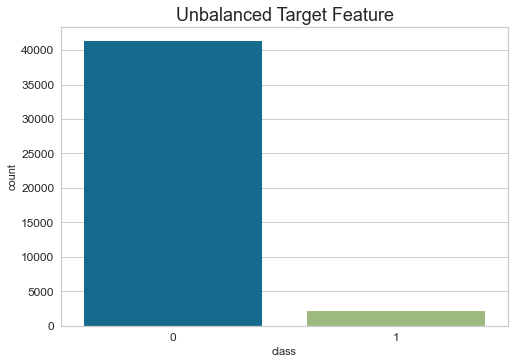

In [15]:

sns.countplot(x='class',data=df) 
plt.title('Unbalanced Target Feature',size=18)
plt.rcParams['axes.spines.right']=False # remove the plot border
plt.rcParams['axes.spines.left']=False # remove the plot border
plt.rcParams['axes.spines.top']=False # remove the plot border
plt.rcParams['axes.spines.bottom']=False # remove the plot border
plt.xticks(size=12)
plt.yticks(size=12) 
plt.show()


#### Find all columns with NA

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43405 entries, 0 to 43404
Data columns (total 65 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Attr1   43397 non-null  float64
 1   Attr2   43397 non-null  float64
 2   Attr3   43397 non-null  float64
 3   Attr4   43271 non-null  float64
 4   Attr5   43316 non-null  float64
 5   Attr6   43397 non-null  float64
 6   Attr7   43397 non-null  float64
 7   Attr8   43311 non-null  float64
 8   Attr9   43396 non-null  float64
 9   Attr10  43397 non-null  float64
 10  Attr11  43361 non-null  float64
 11  Attr12  43271 non-null  float64
 12  Attr13  43278 non-null  float64
 13  Attr14  43397 non-null  float64
 14  Attr15  43369 non-null  float64
 15  Attr16  43310 non-null  float64
 16  Attr17  43311 non-null  float64
 17  Attr18  43397 non-null  float64
 18  Attr19  43277 non-null  float64
 19  Attr20  43278 non-null  float64
 20  Attr21  37551 non-null  float64
 21  Attr22  43397 non-null  float64
 22

#### Missing Data

In [17]:
df.isna().sum()

Attr1       8
Attr2       8
Attr3       8
Attr4     134
Attr5      89
         ... 
Attr61    102
Attr62    127
Attr63    134
Attr64    812
class       0
Length: 65, dtype: int64

In [18]:
df1.isnull().sum().sum()

5835

In [19]:
df.isnull().any()

Attr1      True
Attr2      True
Attr3      True
Attr4      True
Attr5      True
          ...  
Attr61     True
Attr62     True
Attr63     True
Attr64     True
class     False
Length: 65, dtype: bool

#### It is observed, Attr137 and Attr21 has a lot of sparsity. Feature Attr37 has the highest sparsity among all the features. More or less, all the features have missing data samples.

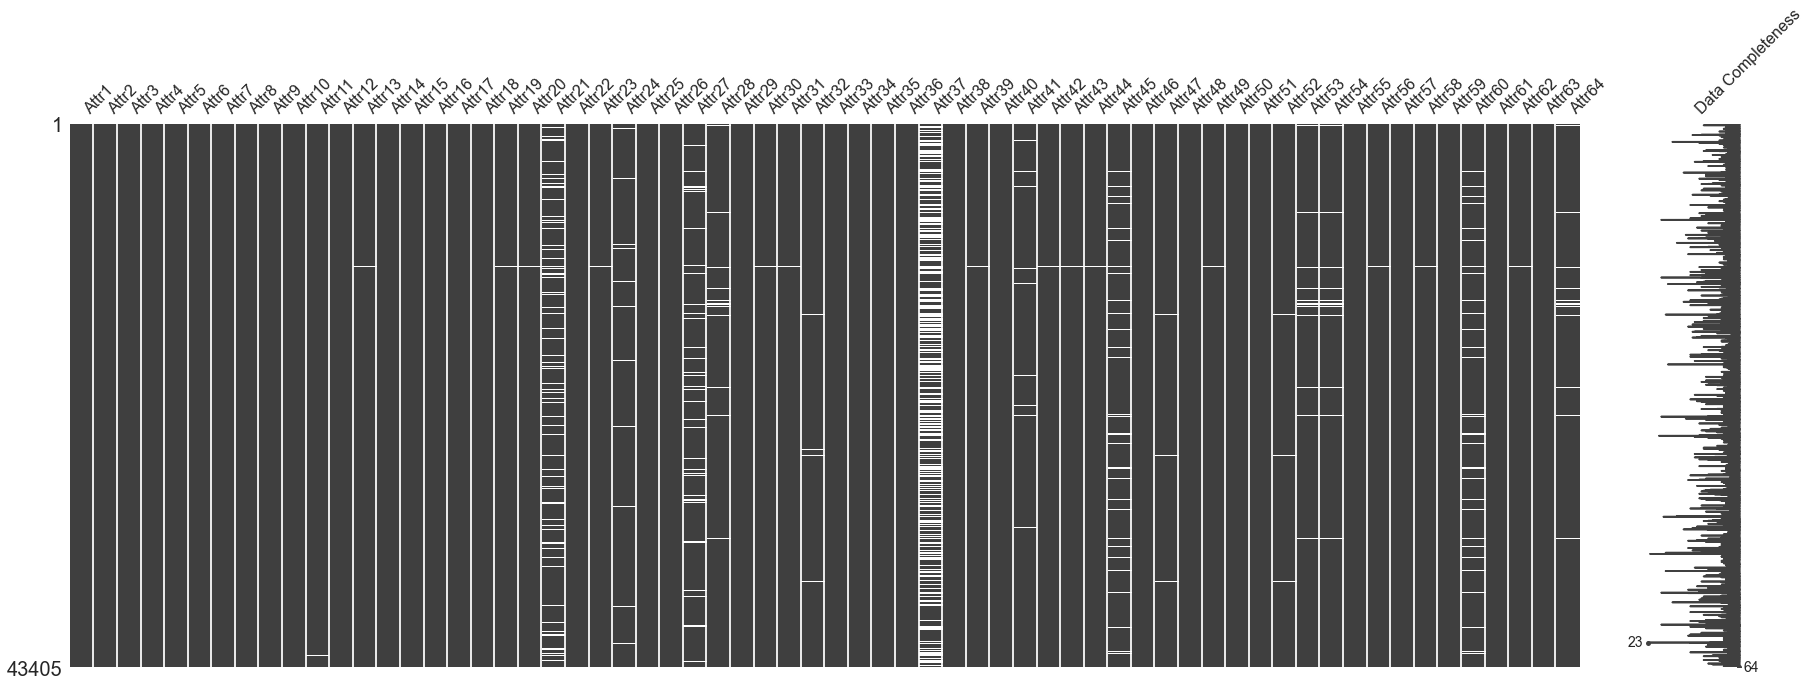

In [20]:
generate_sparsity_matrix(df)

#### By looking boxplot for the features which has maximum missing values. data is so densily colocated. We can use either Mean or Median to impute the data

In [21]:
#df.boxplot(column=['Attr37', 'Attr21', 'Attr27', 'Attr45', 'Attr60'], title="Box plot for missing features")

#### There are not many records which are null. Impute the missing data with median

In [22]:
df_impute = grouper_impute(df)

In [23]:
df_impute.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43405 entries, 0 to 43404
Data columns (total 65 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Attr1   43405 non-null  float64
 1   Attr2   43405 non-null  float64
 2   Attr3   43405 non-null  float64
 3   Attr4   43405 non-null  float64
 4   Attr5   43405 non-null  float64
 5   Attr6   43405 non-null  float64
 6   Attr7   43405 non-null  float64
 7   Attr8   43405 non-null  float64
 8   Attr9   43405 non-null  float64
 9   Attr10  43405 non-null  float64
 10  Attr11  43405 non-null  float64
 11  Attr12  43405 non-null  float64
 12  Attr13  43405 non-null  float64
 13  Attr14  43405 non-null  float64
 14  Attr15  43405 non-null  float64
 15  Attr16  43405 non-null  float64
 16  Attr17  43405 non-null  float64
 17  Attr18  43405 non-null  float64
 18  Attr19  43405 non-null  float64
 19  Attr20  43405 non-null  float64
 20  Attr21  43405 non-null  float64
 21  Attr22  43405 non-null  float64
 22

In [24]:
df_impute.head()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr37,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,0.071010,0.438190,0.169180,1.75070,12.8670,0.00000,0.092551,1.28210,1.88020,0.56181,0.118420,0.410660,0.095523,0.092551,890.51,0.409880,2.28210,0.092551,0.049223,20.093,1.18540,0.115330,0.037766,0.23756,0.55259,0.360720,4.45890,0.279420,4.1144,0.162910,0.061241,46.0530,7.9256,4.07630,0.094037,1.88020,2.2425,0.69159,0.050013,0.60708,0.072171,0.061338,50.03100,29.93800,0.68604,1.29140,21.151,0.028276,0.015038,0.90040,0.225370,0.126170,0.92791,1.14230,2201.600,0.050013,0.12640,0.95288,0.23101,18.1650,12.1920,43.7500,8.3429,3.10550,0
1,0.122350,0.473350,0.450840,1.95250,-3.6710,0.00000,0.156450,1.11260,2.60370,0.52665,0.167860,0.330510,0.115920,0.156450,572.44,0.637620,2.11260,0.156450,0.060087,65.937,1.00000,0.167860,0.046992,0.15645,0.38404,0.565590,14.71200,5.947100,2.5448,0.067136,0.060087,70.9330,5.1457,5.14570,0.167980,2.60370,0.0000,0.52665,0.064515,0.63883,0.050374,0.064469,87.16800,21.23100,0.26013,0.95878,70.484,0.022491,0.008638,1.95250,0.473350,0.194340,6.94710,6.94710,158.060,0.064516,0.23232,0.93992,0.00000,5.5356,17.1920,66.3560,5.5006,34.34500,0
2,-0.627730,1.392900,0.026348,9.10500,9.6232,-0.57493,-0.627730,-0.28205,0.88493,-0.39285,-0.311810,-193.100000,-0.534570,-0.627730,-1074.70,-0.339630,0.71795,-0.627730,-0.709350,0.000,0.39595,-0.312210,-0.709350,-0.80952,-1.20270,-0.339630,-0.98829,0.027151,2.9367,1.543500,-0.380690,1.0541,346.2700,0.80816,-0.240720,0.88493,0.0213,0.99675,-0.272020,8.40460,-0.294700,-0.352810,0.93906,0.93906,0.00000,9.10500,0.000,-0.466890,-0.527600,0.02125,0.003251,0.002888,-0.40484,1.02720,22.775,-0.272020,1.59790,1.64660,-3.53720,0.0000,388.6900,1.3408,272.2200,0.91192,0
3,-0.129080,0.082658,0.239210,3.89400,79.8160,-0.38650,-0.128960,10.64800,0.85313,0.88014,-0.128960,-1.560100,-0.006852,-0.128960,-5436.20,-0.067142,12.09800,-0.128960,-0.159220,24.855,0.92473,-0.126660,-0.159370,-0.38178,0.88014,-0.068573,-1.33420,0.352750,4.2128,-0.086597,-0.159220,31.7800,11.4850,-1.53240,-0.126660,0.83547,0.0000,0.88014,-0.156390,1.85990,-0.834960,-0.156390,75.77300,50.91800,-2.34040,3.22670,21.205,-0.250070,-0.308760,3.89400,0.082658,0.087068,1.29790,1.29790,3904.200,-0.172150,-0.14665,1.17220,0.00000,14.6850,7.1685,37.2510,9.7984,1.19430,0
4,0.038033,0.868250,-0.088667,0.84292,-40.7000,0.00000,0.038033,0.15174,1.75650,0.13175,0.071278,0.067378,0.036388,0.038033,4958.20,0.073616,1.15170,0.038033,0.021652,21.082,1.01780,0.071275,0.021652,0.12883,0.12684,0.073616,2.14390,-0.169150,3.9152,0.487840,0.034654,115.1900,3.1686,2.06000,-0.032035,1.75650,1.4984,0.38158,-0.018237,0.03632,0.297880,0.040577,94.60900,73.52700,0.37488,0.66319,20.704,0.045390,0.025841,0.54799,0.564470,0.315600,0.25133,0.72792,-729.440,-0.018237,0.28868,0.97955,1.89630,17.3140,4.9642,117.2900,3.1119,3.35090,0


In [25]:
X = df_impute.drop("class", axis=1)
y = df_impute["class"].values

# Break our data into 80% training and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1234, stratify=y)

In [26]:
y_train

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

### Building three models RandomForest, XGBoost and Logistic Regression. Logistic regression is for comparision

In [29]:
model_objects = [
            xgb.XGBClassifier(),
            RandomForestClassifier(n_estimators = 5, criterion = 'entropy'),
            LogisticRegression(class_weight='balanced')
        ]
    
model_names = [
        "XGBoost",
        "RandomForest",
        "LogisticRegression"
    ]

model_scores = build_run_models(X_train, y_train, model_objects, model_names)

XGBoost
[18:28:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:28:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:29:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:29:07] WARNING: C:/Users/Administrator/workspace/xgboost-w

In [30]:
model_scores

,Score
XGBoost,0.991668
RandomForest,0.915444
LogisticRegression,0.681594


Text(0.5, 0, 'Mean Accuracy Score')

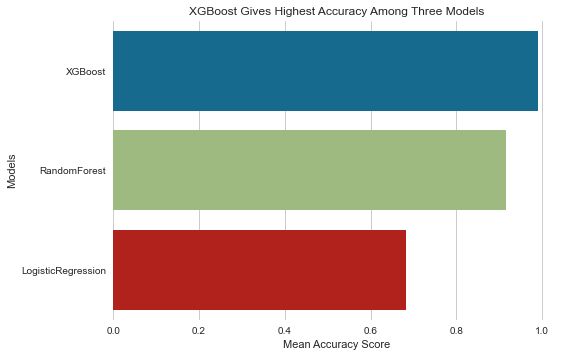

In [31]:
model_comp=model_scores.reset_index()
sns.barplot(x='Score',y='index',data=model_comp)
plt.title('XGBoost Gives Highest Accuracy Among Three Models')
plt.ylabel('Models')
plt.xlabel('Mean Accuracy Score')



#### Running random

In [32]:
rf_model_imbalance = RandomForestClassifier(n_estimators= 300, min_samples_split= 2, max_depth= 10, criterion='entropy', class_weight='balanced')
rf_model_imbalance.fit(X_train, y_train)
y_true_rf_imbalance, y_pred_rf_imbalance = y_test,rf_model_imbalance.predict(X_test)
print(classification_report(y_true_rf_imbalance,y_pred_rf_imbalance))



              precision    recall  f1-score   support

           0       0.99      0.97      0.98      8263
           1       0.59      0.83      0.69       418

    accuracy                           0.96      8681
   macro avg       0.79      0.90      0.83      8681
weighted avg       0.97      0.96      0.97      8681



[[8018  245]
 [  70  348]]


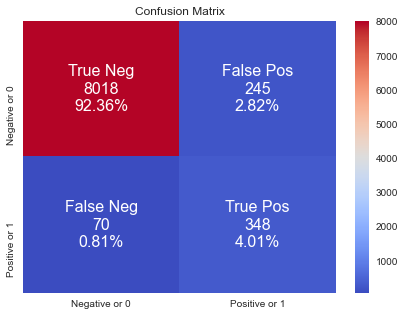

0.963713857850478

In [33]:
# Making the Confusion Matrix
cm = metrics.confusion_matrix(y_test, y_pred_rf_imbalance)
print(cm)
plot_confusion_matrix(y_test, y_pred_rf_imbalance)
accuracy_score(y_test,y_pred_rf_imbalance)

### Because the dataset is imbalanced, performing up sampling using SMOTE

Total Records 66102
Total Classes: 2
Class Gini Index 0.5
Smallest Class Id: 1 Records: 33051
Largest Class Id: 1 Records: 33051
Accuracy when Guessing: 50.0 %


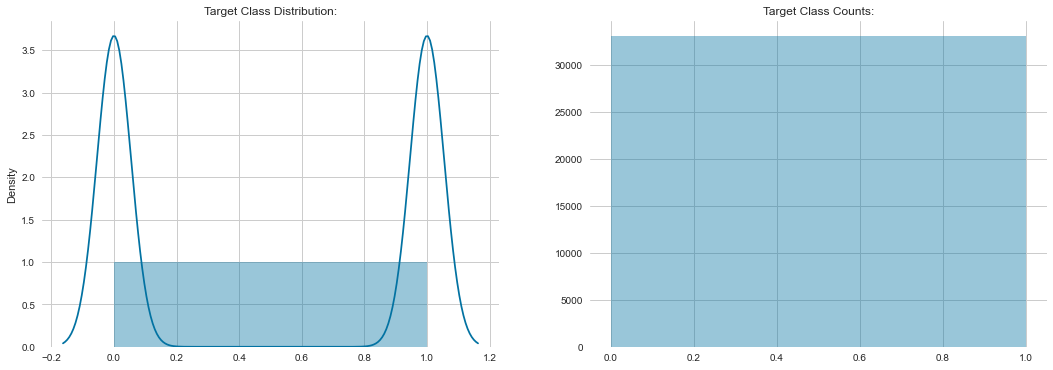

In [34]:
sm = SMOTE(random_state=1234)

X_sm, y_sm = sm.fit_resample(X_train, y_train)

plot_class_dist(y_sm)

In [35]:
model_scores = build_run_models(X_sm, y_sm, model_objects, model_names)

XGBoost
[18:31:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:31:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:31:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:32:09] WARNING: C:/Users/Administrator/workspace/xgboost-w

#### There is improvement in the model score after balancing the dataset

In [36]:
model_scores = build_run_models(X_sm, y_sm, model_objects, model_names)

XGBoost
[18:32:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:32:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:33:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:33:14] WARNING: C:/Users/Administrator/workspace/xgboost-w

In [37]:
model_scores

,Score
XGBoost,0.999788
RandomForest,0.995094
LogisticRegression,0.686549


#### There is improvement in the model score after upsampling using SMOTE

Text(0.5, 0, 'Mean Accuracy Score')

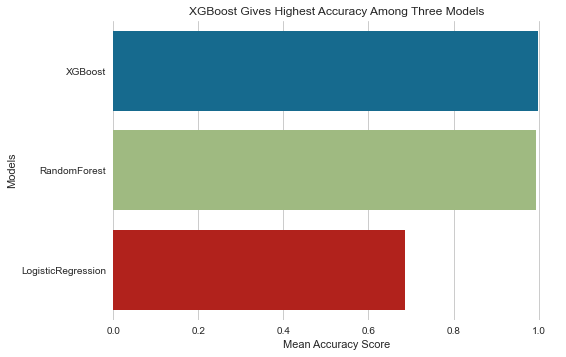

In [38]:
model_comp=model_scores.reset_index()
sns.barplot(x='Score',y='index',data=model_comp)
plt.title('XGBoost Gives Highest Accuracy Among Three Models')
plt.ylabel('Models')
plt.xlabel('Mean Accuracy Score')

### RandomForestClassifier hyperparameters

In [39]:
tunned_parameters = {'n_estimators':[10,50,100,300],
                    'criterion':['gini','entropy'],
                    'max_depth':[5,10,15],
                    'min_samples_split':[2,4,9],
                    'class_weight':["balanced", "balanced_subsample"]
                    }
scores = ['precision','recall']
rf = RandomForestClassifier()

In [40]:

%%time 
for score in scores:
    print('# Tunning hyper-parameters for %s'%score)
    print()
    clf = RandomizedSearchCV(rf,tunned_parameters,cv=5,scoring='%s_macro'%score,n_iter=10)
    clf.fit(X_train,y_train)
    
    print('Best Parameters set found on development set: ')
    print()
    print(clf.best_params_)
    print()
    print('Grid scores on development set:')
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    
    for mean, std, params in zip(means,stds,clf.cv_results_['params']):
        print('%0.3f (+/-%0.3f) for % r'%(mean,std*2,params))
    print()
    
    print('Detailed classification Reports: ')
    print()
    print('The Model is trained on hte full development set.')
    print('The scores are computed on the full evaluation set. ')
    print()
    y_true, y_pred = y_test,clf.predict(X_test)
    print(classification_report(y_true,y_pred))
    print()

# Tunning hyper-parameters for precision

Best Parameters set found on development set: 

{'n_estimators': 300, 'min_samples_split': 4, 'max_depth': 15, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}

Grid scores on development set:

0.920 (+/-0.032) for {'n_estimators': 100, 'min_samples_split': 4, 'max_depth': 15, 'criterion': 'gini', 'class_weight': 'balanced'}
0.805 (+/-0.017) for {'n_estimators': 300, 'min_samples_split': 2, 'max_depth': 10, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}
0.631 (+/-0.018) for {'n_estimators': 10, 'min_samples_split': 2, 'max_depth': 5, 'criterion': 'gini', 'class_weight': 'balanced'}
0.957 (+/-0.013) for {'n_estimators': 300, 'min_samples_split': 4, 'max_depth': 15, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}
0.800 (+/-0.029) for {'n_estimators': 100, 'min_samples_split': 9, 'max_depth': 10, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}
0.628 (+/-0.037) for {'n_estimators': 10, 'min_sampl

In [41]:
rf_model = RandomForestClassifier(n_estimators= 300, min_samples_split= 9, max_depth= 15, criterion='entropy', class_weight='balanced')
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=15, min_samples_split=9, n_estimators=300)

In [43]:
y_true_rf_final, y_pred_rf_final = y_test,rf_model.predict(X_test)

y_true_rf_final_p, y_pred_rf_final_p = y_test, rf_model.predict_proba(X_test)

print(classification_report(y_true_rf_final,y_pred_rf_final))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      8263
           1       0.94      0.72      0.81       418

    accuracy                           0.98      8681
   macro avg       0.96      0.86      0.90      8681
weighted avg       0.98      0.98      0.98      8681



[[8243   20]
 [ 117  301]]


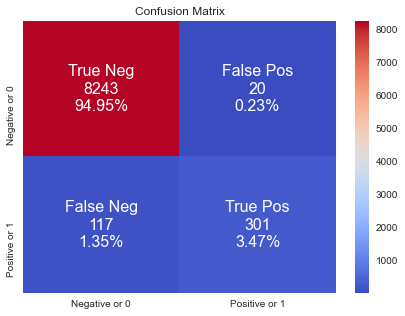

In [44]:
# Making the Confusion Matrix
cm = metrics.confusion_matrix(y_test, y_pred_rf_final)
print(cm)
plot_confusion_matrix(y_test, y_pred_rf_final)

In [45]:
y_pred_rf_final_p

array([[1.        , 0.        ],
       [0.98514631, 0.01485369],
       [0.97736066, 0.02263934],
       ...,
       [0.87151872, 0.12848128],
       [0.91172127, 0.08827873],
       [0.98900369, 0.01099631]])

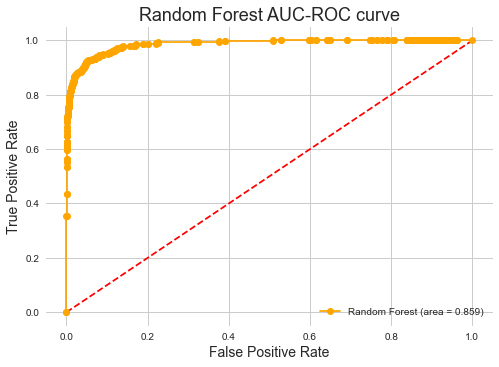

In [46]:
plot_AUC_roc_curve_(y_test,y_pred_rf_final, rf_model, "Random Forest") 

### Random Forest feature importance

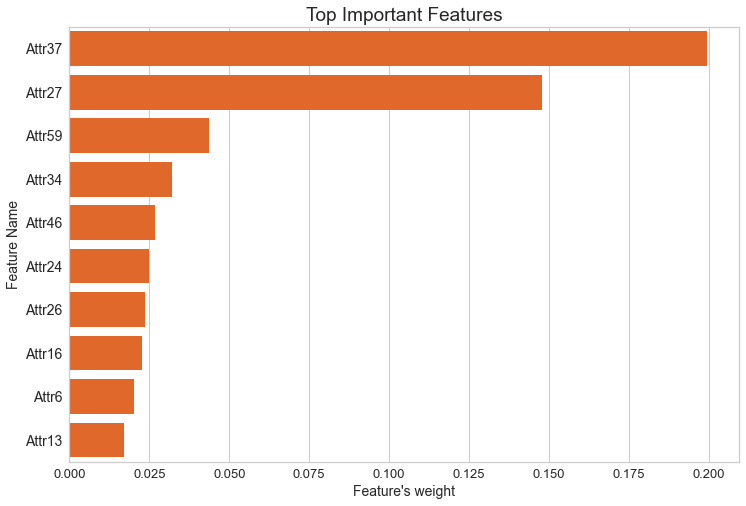

In [47]:

# feature important Series for random forest
important_features = pd.Series(rf_model.feature_importances_,
                        index=X_train.columns.values).sort_values(ascending=False)
ten_important_features=important_features.head(10)
ten_important_features = ten_important_features.reset_index()

top_ten_features = ten_important_features.rename(columns={'index':'features',0:'weights'})

plt.figure(figsize=(12,8))
sns.barplot(y='features',x='weights',data=top_ten_features,color='#FF5E0D')
plt.title('Top Important Features',size=19)
plt.ylabel('Feature Name',size=14)
plt.xlabel("Feature's weight",size=14)
plt.xticks(size=13)
plt.yticks(size=14)
plt.show() 

### XGBoost with Hyperparameters and XGBoost's train and crossvalidation

#### Initialize the parameters

In [48]:
dtrain = xgb.DMatrix(X_train,label=y_train)
dtest = xgb.DMatrix(X_test,label=y_test)
evallist = [(dtest,'eval'), (dtrain,'train')]

In [49]:
num_round = 1000
param = {
    
    'max_depth': 10,
    'objective':'multi:softmax',
    'num_class':2,
    'eta':0.06
}

#### Even though number of rounds set is 1000 XGBoost train stops at 771 rounds as there is no further improvement

In [50]:
%%time
# instead of fit, xgb uses a method called train

xgb_model = xgb.train(param,dtrain,num_round,evallist,early_stopping_rounds=5)


[19:19:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-mlogloss:0.63799	train-mlogloss:0.63764
[1]	eval-mlogloss:0.58916	train-mlogloss:0.58836
[2]	eval-mlogloss:0.54545	train-mlogloss:0.54429
[3]	eval-mlogloss:0.50632	train-mlogloss:0.50471
[4]	eval-mlogloss:0.47098	train-mlogloss:0.46889
[5]	eval-mlogloss:0.43882	train-mlogloss:0.43642
[6]	eval-mlogloss:0.40961	train-mlogloss:0.40692
[7]	eval-mlogloss:0.38298	train-mlogloss:0.38000
[8]	eval-mlogloss:0.35859	train-mlogloss:0.35531
[9]	eval-mlogloss:0.33622	train-mlogloss:0.33269
[10]	eval-mlogloss:0.31570	train-mlogloss:0.31178
[11]	eval-mlogloss:0.29681	train-mlogloss:0.29265
[12]	eval-mlogloss:0.27938	train-mlogloss:0.27484
[13]	eval-mlogloss:0.26326	train-mlogloss:0.25828


[157]	eval-mlogloss:0.03585	train-mlogloss:0.00480
[158]	eval-mlogloss:0.03593	train-mlogloss:0.00471
[159]	eval-mlogloss:0.03589	train-mlogloss:0.00466
[160]	eval-mlogloss:0.03592	train-mlogloss:0.00459
[161]	eval-mlogloss:0.03592	train-mlogloss:0.00452
[162]	eval-mlogloss:0.03594	train-mlogloss:0.00445
[163]	eval-mlogloss:0.03593	train-mlogloss:0.00439
[164]	eval-mlogloss:0.03591	train-mlogloss:0.00433
[165]	eval-mlogloss:0.03600	train-mlogloss:0.00427
[166]	eval-mlogloss:0.03597	train-mlogloss:0.00423
[167]	eval-mlogloss:0.03596	train-mlogloss:0.00418
[168]	eval-mlogloss:0.03599	train-mlogloss:0.00410
[169]	eval-mlogloss:0.03599	train-mlogloss:0.00404
[170]	eval-mlogloss:0.03600	train-mlogloss:0.00402
[171]	eval-mlogloss:0.03607	train-mlogloss:0.00394
[172]	eval-mlogloss:0.03607	train-mlogloss:0.00391
[173]	eval-mlogloss:0.03605	train-mlogloss:0.00385
[174]	eval-mlogloss:0.03610	train-mlogloss:0.00378
[175]	eval-mlogloss:0.03609	train-mlogloss:0.00376
[176]	eval-mlogloss:0.03608	tra

[318]	eval-mlogloss:0.03882	train-mlogloss:0.00104
[319]	eval-mlogloss:0.03886	train-mlogloss:0.00103
[320]	eval-mlogloss:0.03887	train-mlogloss:0.00103
[321]	eval-mlogloss:0.03889	train-mlogloss:0.00102
[322]	eval-mlogloss:0.03888	train-mlogloss:0.00102
[323]	eval-mlogloss:0.03890	train-mlogloss:0.00101
[324]	eval-mlogloss:0.03893	train-mlogloss:0.00101
[325]	eval-mlogloss:0.03895	train-mlogloss:0.00101
[326]	eval-mlogloss:0.03897	train-mlogloss:0.00100
[327]	eval-mlogloss:0.03893	train-mlogloss:0.00099
[328]	eval-mlogloss:0.03896	train-mlogloss:0.00098
[329]	eval-mlogloss:0.03894	train-mlogloss:0.00098
[330]	eval-mlogloss:0.03894	train-mlogloss:0.00098
[331]	eval-mlogloss:0.03894	train-mlogloss:0.00097
[332]	eval-mlogloss:0.03891	train-mlogloss:0.00097
[333]	eval-mlogloss:0.03892	train-mlogloss:0.00096
[334]	eval-mlogloss:0.03894	train-mlogloss:0.00096
[335]	eval-mlogloss:0.03898	train-mlogloss:0.00095
[336]	eval-mlogloss:0.03903	train-mlogloss:0.00094
[337]	eval-mlogloss:0.03905	tra

[479]	eval-mlogloss:0.04086	train-mlogloss:0.00052
[480]	eval-mlogloss:0.04088	train-mlogloss:0.00052
[481]	eval-mlogloss:0.04088	train-mlogloss:0.00051
[482]	eval-mlogloss:0.04090	train-mlogloss:0.00051
[483]	eval-mlogloss:0.04091	train-mlogloss:0.00051
[484]	eval-mlogloss:0.04092	train-mlogloss:0.00051
[485]	eval-mlogloss:0.04092	train-mlogloss:0.00051
[486]	eval-mlogloss:0.04092	train-mlogloss:0.00051
[487]	eval-mlogloss:0.04093	train-mlogloss:0.00050
[488]	eval-mlogloss:0.04092	train-mlogloss:0.00050
[489]	eval-mlogloss:0.04095	train-mlogloss:0.00050
[490]	eval-mlogloss:0.04096	train-mlogloss:0.00050
[491]	eval-mlogloss:0.04097	train-mlogloss:0.00050
[492]	eval-mlogloss:0.04097	train-mlogloss:0.00050
[493]	eval-mlogloss:0.04100	train-mlogloss:0.00050
[494]	eval-mlogloss:0.04099	train-mlogloss:0.00049
[495]	eval-mlogloss:0.04103	train-mlogloss:0.00049
[496]	eval-mlogloss:0.04104	train-mlogloss:0.00049
[497]	eval-mlogloss:0.04106	train-mlogloss:0.00049
[498]	eval-mlogloss:0.04106	tra

[640]	eval-mlogloss:0.04235	train-mlogloss:0.00035
[641]	eval-mlogloss:0.04237	train-mlogloss:0.00035
[642]	eval-mlogloss:0.04239	train-mlogloss:0.00035
[643]	eval-mlogloss:0.04240	train-mlogloss:0.00035
[644]	eval-mlogloss:0.04240	train-mlogloss:0.00035
[645]	eval-mlogloss:0.04241	train-mlogloss:0.00035
[646]	eval-mlogloss:0.04242	train-mlogloss:0.00035
[647]	eval-mlogloss:0.04243	train-mlogloss:0.00035
[648]	eval-mlogloss:0.04245	train-mlogloss:0.00035
[649]	eval-mlogloss:0.04243	train-mlogloss:0.00035
[650]	eval-mlogloss:0.04244	train-mlogloss:0.00034
[651]	eval-mlogloss:0.04245	train-mlogloss:0.00034
[652]	eval-mlogloss:0.04245	train-mlogloss:0.00034
[653]	eval-mlogloss:0.04246	train-mlogloss:0.00034
[654]	eval-mlogloss:0.04246	train-mlogloss:0.00034
[655]	eval-mlogloss:0.04246	train-mlogloss:0.00034
[656]	eval-mlogloss:0.04247	train-mlogloss:0.00034
[657]	eval-mlogloss:0.04247	train-mlogloss:0.00034
[658]	eval-mlogloss:0.04248	train-mlogloss:0.00034
[659]	eval-mlogloss:0.04250	tra

[961]	eval-mlogloss:0.04412	train-mlogloss:0.00023
[962]	eval-mlogloss:0.04411	train-mlogloss:0.00023
[963]	eval-mlogloss:0.04411	train-mlogloss:0.00023
[964]	eval-mlogloss:0.04412	train-mlogloss:0.00023
[965]	eval-mlogloss:0.04413	train-mlogloss:0.00023
[966]	eval-mlogloss:0.04413	train-mlogloss:0.00023
[967]	eval-mlogloss:0.04412	train-mlogloss:0.00023
[968]	eval-mlogloss:0.04413	train-mlogloss:0.00023
[969]	eval-mlogloss:0.04414	train-mlogloss:0.00023
[970]	eval-mlogloss:0.04414	train-mlogloss:0.00023
[971]	eval-mlogloss:0.04415	train-mlogloss:0.00023
[972]	eval-mlogloss:0.04416	train-mlogloss:0.00023
[973]	eval-mlogloss:0.04416	train-mlogloss:0.00022
[974]	eval-mlogloss:0.04417	train-mlogloss:0.00022
[975]	eval-mlogloss:0.04417	train-mlogloss:0.00022
[976]	eval-mlogloss:0.04417	train-mlogloss:0.00022
[977]	eval-mlogloss:0.04417	train-mlogloss:0.00022
[978]	eval-mlogloss:0.04417	train-mlogloss:0.00022
[979]	eval-mlogloss:0.04418	train-mlogloss:0.00022
[980]	eval-mlogloss:0.04418	tra

In [51]:
%%time 
# Cross Validation
# num_boost_round = number of iteration
output = xgb.cv(params=param,
       dtrain=dtrain,
       num_boost_round=num_round, 
       nfold=5,
       verbose_eval=True,
       early_stopping_rounds=5) 

[19:22:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:22:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:22:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:22:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[101]	train-mlogloss:0.01048+0.00060	test-mlogloss:0.04251+0.00440
[102]	train-mlogloss:0.01027+0.00058	test-mlogloss:0.04244+0.00439
[103]	train-mlogloss:0.01010+0.00057	test-mlogloss:0.04240+0.00444
[104]	train-mlogloss:0.00992+0.00056	test-mlogloss:0.04235+0.00441
[105]	train-mlogloss:0.00971+0.00058	test-mlogloss:0.04228+0.00440
[106]	train-mlogloss:0.00954+0.00061	test-mlogloss:0.04226+0.00441
[107]	train-mlogloss:0.00934+0.00060	test-mlogloss:0.04219+0.00440
[108]	train-mlogloss:0.00915+0.00055	test-mlogloss:0.04213+0.00443
[109]	train-mlogloss:0.00896+0.00054	test-mlogloss:0.04203+0.00446
[110]	train-mlogloss:0.00882+0.00052	test-mlogloss:0.04195+0.00442
[111]	train-mlogloss:0.00862+0.00049	test-mlogloss:0.04184+0.00444
[112]	train-mlogloss:0.00846+0.00049	test-mlogloss:0.04183+0.00445
[113]	train-mlogloss:0.00834+0.00047	test-mlogloss:0.04182+0.00446
[114]	train-mlogloss:0.00814+0.00046	test-mlogloss:0.04180+0.00453
[115]	train-mlogloss:0.00802+0.00045	test-mlogloss:0.04175+0.0

In [52]:
output

,train-mlogloss-mean,train-mlogloss-std,test-mlogloss-mean,test-mlogloss-std
0,0.637527,0.000129,0.638239,0.000211
1,0.588166,0.000237,0.589480,0.000317
2,0.544038,0.000376,0.545924,0.000367
3,0.504450,0.000458,0.506932,0.000517
4,0.468662,0.000496,0.471708,0.000627
...,...,...,...,...
120,0.007258,0.000446,0.041676,0.004477
121,0.007127,0.000466,0.041678,0.004481
122,0.007013,0.000450,0.041640,0.004468
123,0.006909,0.000405,0.041596,0.004498


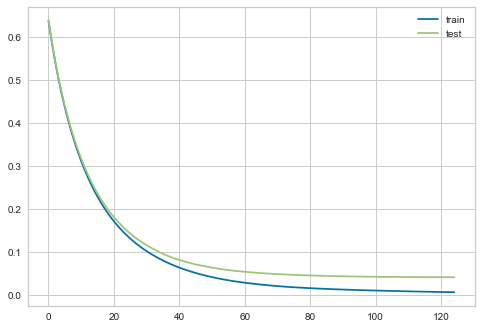

In [53]:
plt.plot(output['train-mlogloss-mean'],label='train')
plt.plot(output['test-mlogloss-mean'],label='test')
plt.legend()
plt.show()

In [54]:
y_true_xgb, y_pred_xgb_final = y_test, xgb_model.predict(dtest)


In [55]:
accuracy_score(y_test,y_pred_xgb_final)

0.9895173367123603

[[8255    8]
 [  83  335]]


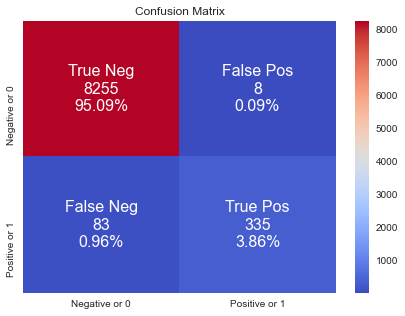

0.9895173367123603
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      8263
           1       0.98      0.80      0.88       418

    accuracy                           0.99      8681
   macro avg       0.98      0.90      0.94      8681
weighted avg       0.99      0.99      0.99      8681



In [56]:
# Making the Confusion Matrix
cm = metrics.confusion_matrix(y_test, y_pred_xgb_final)
print(cm)
plot_confusion_matrix(y_test, y_pred_xgb_final)

print(accuracy_score(y_test, y_pred_xgb_final))
print(classification_report(y_true_xgb, y_pred_xgb_final))



### XGBclassifier:

In [57]:
xgb_clf = xgb.XGBClassifier()

In [58]:
xgb_clf.fit(X_train,y_train,eval_set=[(X_test,y_pred_xgb_final)],eval_metric='auc',verbose=10)

[0]	validation_0-auc:0.97541
[10]	validation_0-auc:0.99523
[20]	validation_0-auc:0.99888
[30]	validation_0-auc:0.99928
[40]	validation_0-auc:0.99960
[50]	validation_0-auc:0.99959
[60]	validation_0-auc:0.99970
[70]	validation_0-auc:0.99977
[80]	validation_0-auc:0.99981
[90]	validation_0-auc:0.99984
[99]	validation_0-auc:0.99986


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=26, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [59]:
print('Train Accuracy Score: %.2f'%xgb_clf.score(X_train,y_train)) 

Train Accuracy Score: 1.00


In [60]:
y_pred=xgb_clf.predict(X_test)

In [61]:
y_pred_prob=xgb_clf.predict_proba(X_test)

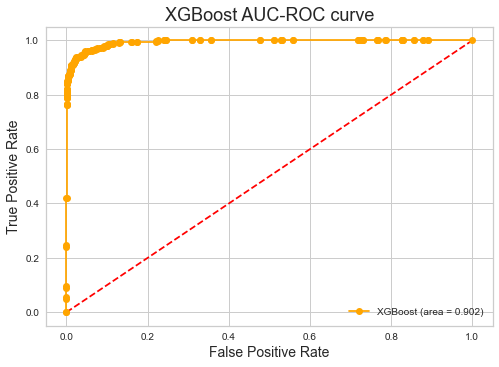

In [62]:
plot_AUC_roc_curve_(y_test,y_pred,xgb_clf, "XGBoost")

### GridSearch For XGBClassifier 

In [63]:
%%time 
tunned_parameters = {
    
    'max_depth': [10,50,100],
    'n_estimators':[50,200,400],
    #'num_class':2,
    'eta':[0.06,0.5,1]
}

grid_search = GridSearchCV(xgb.XGBClassifier(),tunned_parameters,n_jobs=-1,cv=5) 
grid_search.fit(X_train.values,y_train)


print('Best Parametes:', grid_search.best_params_)

[19:37:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best Parametes: {'eta': 0.5, 'max_depth': 50, 'n_estimators': 400}
Wall time: 13min 45s


### XGB classifier on Tunned Parameters: 

In [64]:
xgb_clfs = xgb.XGBClassifier(eta=0.5,max_depth=10,n_estimator=200)

In [65]:
xgb_clfs

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, eta=0.5, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=10,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimator=200, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None)

In [66]:
xgb_clfs.fit(X_train,y_train,eval_set=[(X_test,y_pred_xgb_final)],eval_metric='auc',verbose=10)

[19:38:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimator" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.98405
[10]	validation_0-auc:0.99906
[20]	validation_0-auc:0.99981
[30]	validation_0-auc:0.99989
[40]	validation_0-auc:0.99990
[50]	validation_0-auc:0.99994
[60]	validation_0-auc:0.99995
[70]	validation_0-auc:0.99996
[80]	validation_0-auc:0.99996
[90]	validation_0-auc:0.99996
[99]	validation_0-auc:0.99996


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.5, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.5, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimator=200, n_estimators=100, n_jobs=26, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [67]:
print('Test Accuracy Score: %.2f'%xgb_clf.score(X_test,y_test)) 

Test Accuracy Score: 0.99


In [71]:
y_pred_tunned=xgb_clfs.predict(X_test)

y_pred_prob_tunned=xgb_clfs.predict_proba(X_test)

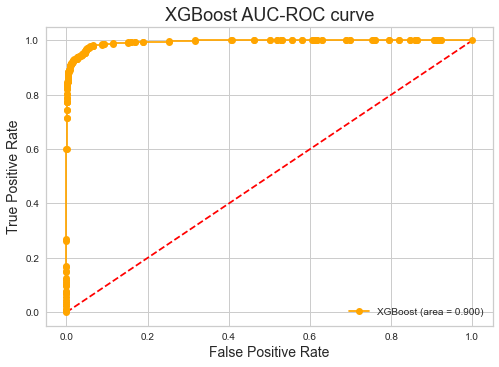

In [74]:
plot_AUC_roc_curve_(y_test,y_pred_tunned,xgb_clfs, "XGBoost")

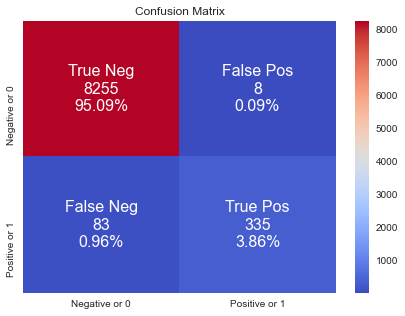

In [75]:
cm = metrics.confusion_matrix(y_test, y_pred_tunned)
#print(cm)
plot_confusion_matrix(y_test, y_pred_tunned)

In [76]:
clf_report=classification_report(y_test,y_pred_tunned)

In [77]:
print(clf_report)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      8263
           1       0.98      0.80      0.88       418

    accuracy                           0.99      8681
   macro avg       0.98      0.90      0.94      8681
weighted avg       0.99      0.99      0.99      8681



In [78]:
met_df=pd.DataFrame(columns=['F1Score','ROC Score','Accuracy'],index=['RF','XGB'])

In [79]:
met_df['ROC Score']=metrics.roc_auc_score(y_test,y_pred_tunned)

In [80]:
met_df=pd.DataFrame({'ROC Score':[metrics.roc_auc_score(y_test, y_pred_rf_imbalance),metrics.roc_auc_score(y_test,y_pred_tunned)],
              'F1Score':[metrics.f1_score(y_test, y_pred_rf_imbalance),metrics.f1_score(y_test,y_pred_tunned)],
              'Accuracy':[metrics.accuracy_score(y_test, y_pred_rf_imbalance),metrics.accuracy_score(y_test,y_pred_tunned)]           
             },index=['RF','XGB']) 
met_df

,ROC Score,F1Score,Accuracy
RF,0.901443,0.688427,0.963714
XGB,0.900234,0.880420,0.989517
